# I. Introduction:
Cancer-Net BCa is a large-scale breast MRI image dataset for the prediction of pCR. The dataset consists of two classes: No pCR (0), and pCR (1). The images are provided as a single directory, and labels for the images are provided in the metadata file.

# II. Loading the Image Data and Metadata:

The image data is stored in a single directory, namely CDIs_images_nifti. Labels are provided in the metadata named metadata.csv.

# II. 1/ Importing Libraries:

In [1]:
import os
import nibabel as nib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# keeps the plots in one place. calls image as static pngs
%matplotlib inline 
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec # subplots
import mpld3 as mpl

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

# II. 2/ Exploring Some Images:

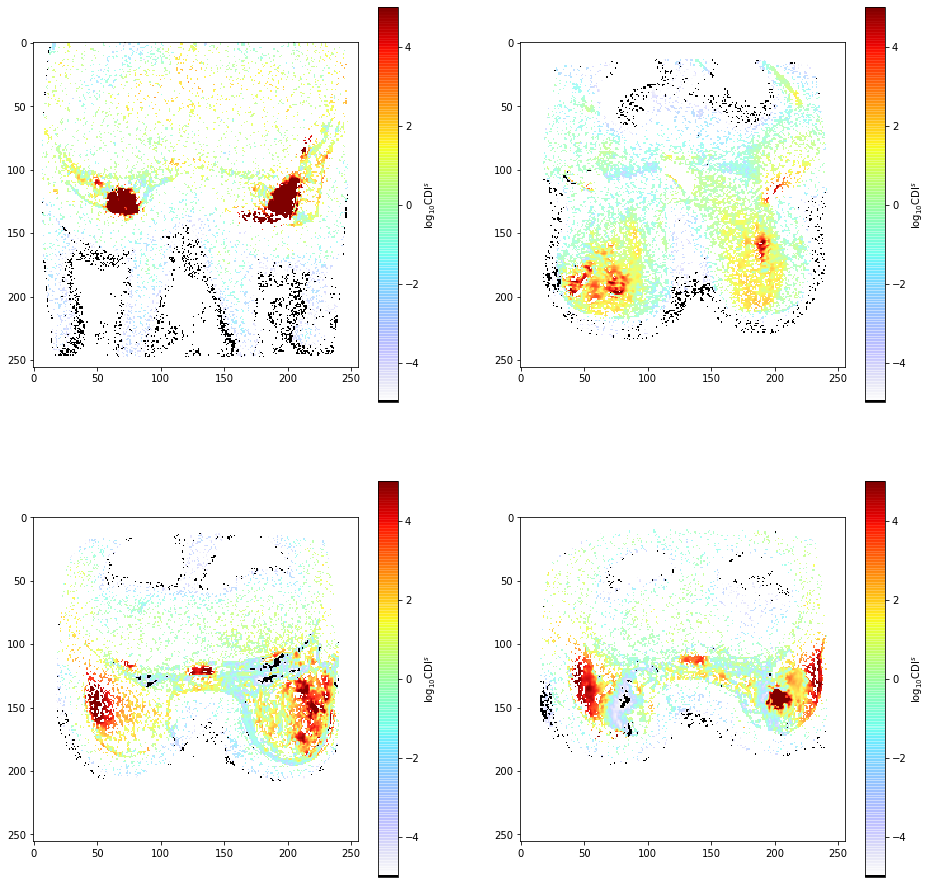

In [2]:
# Set paths
image_dir = 'CDIs_images_nifti'

# Set display range (in log10 scale, see below)
display_range = (-5, 5)

# Select cases to view
np.random.seed(28)
patient_file_list = os.listdir(image_dir)
indices = np.random.choice(list(range(len(patient_file_list))), 9)

# Show a grid of 4 images
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
class_names = ('No pCR', 'pCR')
for index, ax in zip(indices, axes.ravel()):
    # Load the MRI image
    cdis_file = os.path.join(image_dir, patient_file_list[index])
    cdis_volume = nib.load(cdis_file).get_fdata()
    
    # Grab middle slice
    cdis_display = cdis_volume[..., cdis_volume.shape[-1]//2]
    
    # Convert to log10 scale
    valid = cdis_display > 0
    cdis_display[valid] = np.log10(cdis_display[valid])
    
    # Mask invalid voxels
    cdis_display = np.ma.array(cdis_display, mask=~valid)

    # Get class
    patient_id = patient_file_list[index].split('_')[0]
    #cls = int(metadata.loc[metadata['patient_id'] == patient_id]['pCR'].values[0])
    
    # Display slice
    cmap = plt.cm.get_cmap('jet')
    cmap_modified = cmap(np.arange(cmap.N))
    cmap_modified[:, -1] = np.linspace(0, 1, cmap.N)  # Adjust alpha values (optional)
    cmap_modified[0] = [0, 0, 0, 1]  # Set the 'bad' color to black
    cmap_modified = mcolors.ListedColormap(cmap_modified)
    
    im = ax.imshow(
        cdis_display, interpolation='none', cmap=cmap_modified,
        vmin=display_range[0], vmax=display_range[1]
    )
    plt.colorbar(im, ax=ax, label='$\log_{10}$CDI$^s$')
    #ax.set_title('Class: {} ({})'.format(class_names[cls], cls))
    #ax.axis('off')
plt.show()

In [3]:
import glob
nii_files = glob.glob(os.path.join(image_dir, '*.nii'))
num_images = len(nii_files)
print("Number of .nii images:", num_images)

Number of .nii images: 253


# II.3/ Clean and prepare data

In [4]:
df = pd.read_csv("metadata.csv")
df.head()

,patient_id,pCR,age,race,lesion type,HR/HER2,SBR grade,MRLD,analysis cohort
0,ACRIN-6698-115987,False,42.0,Multiple Races,Multiple masses,HR - / HER2 - (TN),III (High),4.0,False
1,ACRIN-6698-860901,True,49.0,NaN,Single mass,HR - / HER2 - (TN),III (High),4.6,True
2,ACRIN-6698-413211,False,66.0,White,Multiple masses,HR + / HER2 +,III (High),3.4,True
3,ACRIN-6698-801641,False,53.0,White,Multiple masses,HR - / HER2 - (TN),III (High),3.9,True
4,ACRIN-6698-408692,True,25.0,White,Multiple masses,HR - / HER2 - (TN),III (High),4.3,True


In [5]:
df.columns

Index(['patient_id', 'pCR', 'age', 'race', 'lesion type', 'HR/HER2',
       'SBR grade', 'MRLD', 'analysis cohort'],
      dtype='object')

In [6]:
df.drop('patient_id',axis=1,inplace=True)
# size of the dataframe
len(df)

253

In [7]:
df.pCR.unique()

array([False,  True])

Perfect! We observe we only have two classes of pCR (labels): False or True.

In [8]:
df['pCR'] = df['pCR'].map({False:0,True:1})
df.head()

,pCR,age,race,lesion type,HR/HER2,SBR grade,MRLD,analysis cohort
0,0,42.0,Multiple Races,Multiple masses,HR - / HER2 - (TN),III (High),4.0,False
1,1,49.0,NaN,Single mass,HR - / HER2 - (TN),III (High),4.6,True
2,0,66.0,White,Multiple masses,HR + / HER2 +,III (High),3.4,True
3,0,53.0,White,Multiple masses,HR - / HER2 - (TN),III (High),3.9,True
4,1,25.0,White,Multiple masses,HR - / HER2 - (TN),III (High),4.3,True


In [9]:
df.pCR.unique()

array([0, 1], dtype=int64)

In [14]:
# Assuming 'pCR' is the column in the DataFrame for which you want to count missing values
missing_values_count = df['pCR'].isna().sum()

print("Number of missing values in 'pCR':", missing_values_count)

Number of missing values in 'pCR': 0


# Explore Data

In [10]:
df.describe()

,pCR,age,MRLD
count,253.000000,253.000000,253.000000
mean,0.324111,48.079051,4.227826
std,0.468969,10.528197,2.241564
min,0.000000,23.000000,0.440000
25%,0.000000,41.000000,2.800000
50%,0.000000,48.000000,3.500000
75%,1.000000,56.000000,5.000000
max,1.000000,77.000000,15.000000


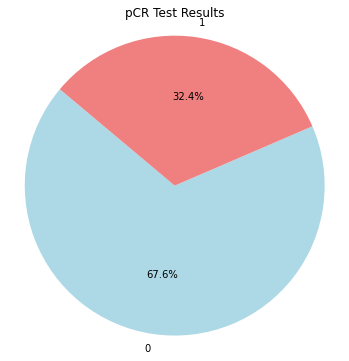

In [13]:
pCR_values = df['pCR'].value_counts()
labels = pCR_values.index
sizes = pCR_values.values
colors = ['lightblue', 'lightcoral']  # You can choose custom colors if you prefer

# Create the circle plot (pie chart)
plt.figure(figsize=(6, 6))  # Set the size of the plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that the plot is circular
plt.title('pCR Test Results')  # Set the title of the plot
plt.show()